# Chapter 9 - Support Vector Machines

- [9.1 Support Vector Classifier](#9.1-Support-Vector-Classifier)
- [9.2 Support Vector Machine](#9.2-Support-Vector-Machine)
- [9.3 ROC Curves](#9.3-ROC-Curves)
- [9.4 SVM with Multiple Classes](#9.4-SVM-with-Multiple-Classes)
- [9.5 Application to Gene Expression Data](#9.5-Application-to-Gene-Expression-Data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

%matplotlib inline
plt.style.use('seaborn-white')

#### Generate Default Data

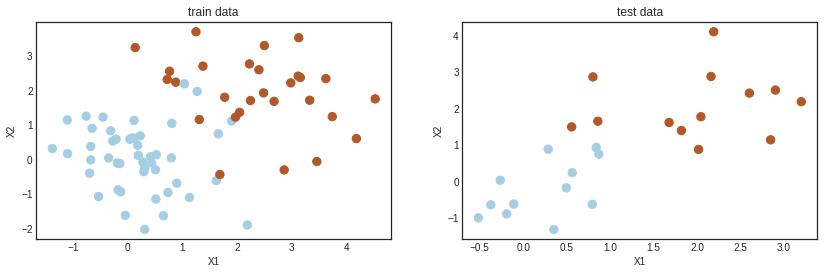

In [2]:
# Generating data
np.random.seed(1)
X = np.random.randn(100, 2)
y = np.random.choice([-1, 1], X.shape[0])
X[y == 1] = X[y == 1] + 2

X_train, X_test, y_train, y_test = train_test_split(X, y)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.scatter(X_train[:, 0], X_train[:, 1], s=70, c=y_train, cmap=plt.cm.Paired)
ax2.scatter(X_test[:, 0], X_test[:, 1], s=70, c=y_test, cmap=plt.cm.Paired)
ax1.set_title('train data')
ax2.set_title('test data')
for ax in [ax1, ax2]:
    ax.set_xlabel('X1')
    ax.set_ylabel('X2');

## 9.1 Support Vector Classifier

Let's train your first svm model

In [3]:
svc = SVC(C=1, kernel='linear')  # kernel = 'linear' 가 되어야 support vector 가 됨.
svc.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [13]:
def get_svc_plot(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    plt.scatter(X[:, 0], X[:, 1], s=70, c=y, cmap=plt.cm.Paired)  # data의 class 별로 다른 color
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:, 0], sv[:, 1], c='k', marker='|', s=100, linewidths=1)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')

    return plt

Define a function to plot a classifier with support vectors.

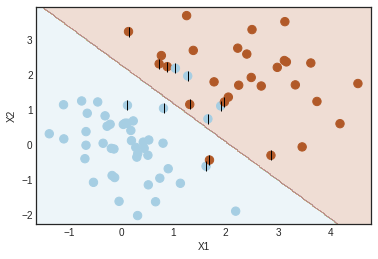

Number of support vectors:  14


In [4]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:, 0], X[:, 1], s=70, c=y, cmap=plt.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:, 0], sv[:, 1], c='k', marker='|', s=100, linewidths=1)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)
    
plot_svc(svc, X_train, y_train)

#### Exercise: Train SVM models with different cost parameters (C = 0.01, 0.1, 1, 10, 100), and plot the SVMs with ```plot_svc``` [3 min]

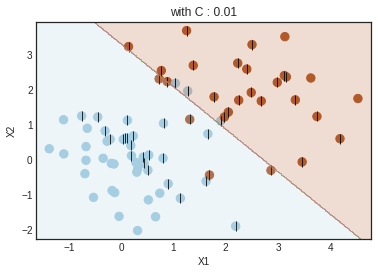

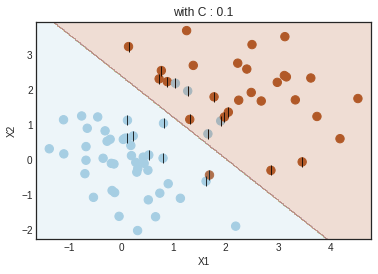

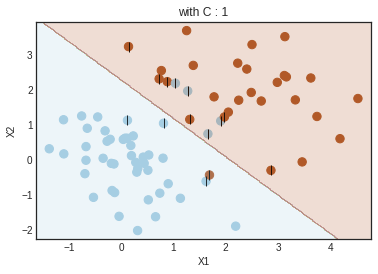

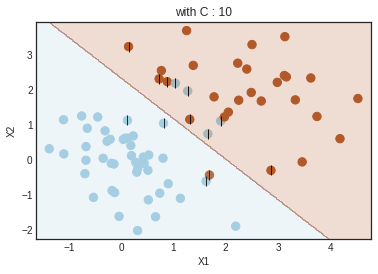

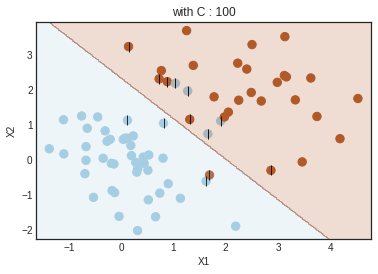

In [25]:
c_list = [0.01, 0.1, 1, 10, 100]

for i, c in enumerate(c_list):
    svc = SVC(C=c, kernel='linear')  # kernel = 'linear' 가 되어야 support vector 가 됨.
    svc.fit(X_train, y_train)
    plt = get_svc_plot(svc, X_train, y_train)
    plt.title(f'with C : {c}')
    plt.show()

#### Exercise: Find the optimal C parameter with cross-validation [3 min]
* Use ```GridSearch```

In [45]:
# TODO
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
svc = GridSearchCV(
    SVC(kernel='linear'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=True
)
svc.fit(X_train, y_train)

print(f'best param : {svc.best_params_}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best param : {'C': 0.1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.1s finished


#### Generate mixed data near the boundary

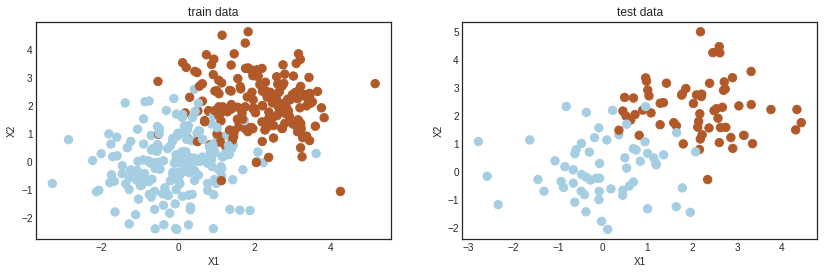

In [46]:
np.random.seed(5)
X = np.random.randn(500, 2)
y = np.random.choice([-1, 1], X.shape[0])
X[y == 1] = X[y == 1] + 2

X_train, X_test, y_train, y_test = train_test_split(X, y)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.scatter(X_train[:, 0], X_train[:, 1], s=70, c=y_train, cmap=plt.cm.Paired)
ax2.scatter(X_test[:, 0], X_test[:, 1], s=70, c=y_test, cmap=plt.cm.Paired)
ax1.set_title('train data')
ax2.set_title('test data')
for ax in [ax1, ax2]:
    ax.set_xlabel('X1')
    ax.set_ylabel('X2');

#### Train and plot SVMs with different C parameters (C = 0.01, 0.1, 1, 10, 100). [3 min]
#### The best paramter would be smaller or larger.

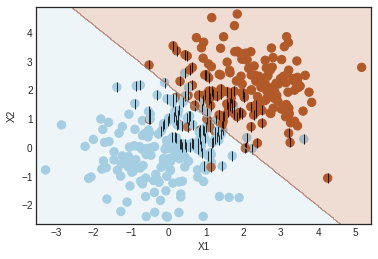

Number of support vectors:  154


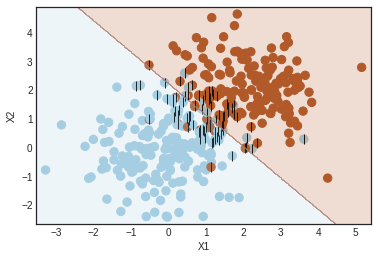

Number of support vectors:  86


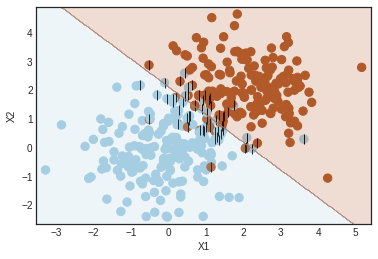

Number of support vectors:  64


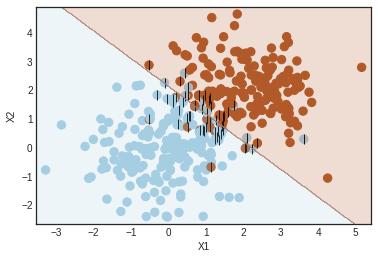

Number of support vectors:  61


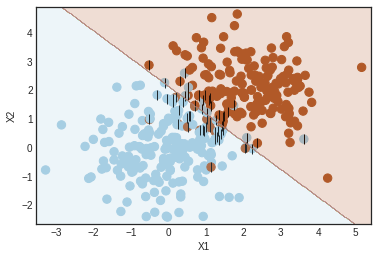

Number of support vectors:  61


In [47]:
# Try yourself fitting SVMs with different C parameters.
# When using a smaller cost parameter (C=0.1) the margin is wider, resulting in more support vectors.
for C in [0.01, 0.1, 1, 10, 100]:
    svc = SVC(C=C, kernel='linear')
    svc.fit(X_train, y_train)
    plot_svc(svc, X_train, y_train)

#### Exercise: Find the optimal C parameter with cross-validation [3 min]

In [52]:
# TODO
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}
svc = GridSearchCV(
    SVC(kernel='linear'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=True
)
svc.fit(X_train, y_train)

print(f'best param : {svc.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best param : {'C': 100}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


## 9.2 Support Vector Machine 

#### Generate non-linear data

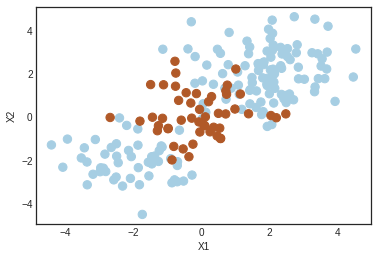

In [53]:
np.random.seed(8)
X = np.random.randn(200, 2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1, 50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

plt.scatter(X[:, 0], X[:, 1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

#### RBF kernel

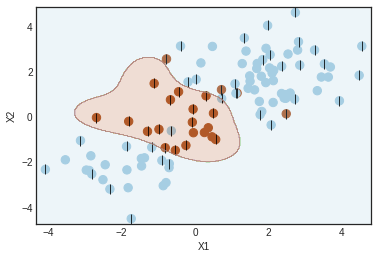

Number of support vectors:  51


In [57]:
svm = SVC(C=1, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)
plot_svc(svm, X_train, y_train)

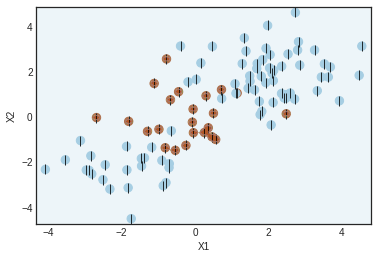

Number of support vectors:  99


In [55]:
# Increasing C parameter, allowing more flexibility
svm2 = SVC(C=1, kernel='rbf', gamma=50)
svm2.fit(X_train, y_train)
plot_svc(svm2, X_train, y_train)

#### Exercise: Train and plot SVMs with different C (0.01, 0.1, 1, 10, 100) and gamma (0.5, 1, 2, 3, 4) parameters. [3 min]

In [61]:
# TODO
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.5, 1, 2, 3, 4]
}
svc = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
)
svc.fit(X_train, y_train)

# print(svc.cv_results_)
print(f'best param : {svc.best_params_}')

best param : {'C': 1, 'gamma': 0.5}


## 9.3 ROC Curves

Comparing the ROC curves of two models on train/test data. One model is more flexible than the other.

In [ ]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

In [ ]:
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

In [ ]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

# Plot ROC curve for the test data

y_test_score5 = svm3.decision_function(X_test)
y_test_score6 = svm4.decision_function(X_test)

false_pos_rate5, true_pos_rate5, _ = roc_curve(y_test, y_test_score5)
roc_auc5 = auc(false_pos_rate5, true_pos_rate5)

false_pos_rate6, true_pos_rate6, _ = roc_curve(y_test, y_test_score6)
roc_auc6 = auc(false_pos_rate6, true_pos_rate6)

ax2.plot(false_pos_rate5, true_pos_rate5, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc5, color='b')
ax2.plot(false_pos_rate6, true_pos_rate6, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc6, color='r')

ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

As expected, the more flexible model scores better on training data but worse on the test data.

## 9.4 SVM with Multiple Classes

#### Generate dataset of multiple classes

In [ ]:
# Adding a third class of observations
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50, 2)])
yy = np.hstack([y, np.repeat(0, 50)])
XX[yy ==0] = XX[yy == 0] + 4

plt.scatter(XX[:, 0], XX[:, 1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2');

In [ ]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)
plot_svc(svm5, XX, yy)

## 9.5 Application to Gene Expression Data

#### Load genetic data

In [ ]:
X_train = pd.read_csv('Data/Khan_xtrain.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('Data/Khan_ytrain.csv').drop('Unnamed: 0', axis=1).values.ravel()
X_test = pd.read_csv('Data/Khan_xtest.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('Data/Khan_ytest.csv').drop('Unnamed: 0', axis=1).values.ravel()

In [ ]:
# Default model
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

#### Exercise: Try Yourself to Improve the Model Accuracy (~0.95) [3 min]

In [ ]:
# TODO
